In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers

from torch.utils.data import DataLoader
from model_util import SequenceDataset, DistilBertData

import numpy as np
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

EPOCHS = 10
MAX_STRING_LENGTH = 29
batch_size = 8
SAVE_SPACE = True # deletes data structures not needed from dataset

PROBLEM = "04.03.TSL.2.1.8" #"04.04.SL.2.1.8" # "16.16.SL.2.1.9"
RESULTS_PATH = "../trained_models/"

DATASET_CONTAINER_PATH = "dataset_problem_{}.pk".format(PROBLEM) # where to save dataset metadata 

TRAIN_DATA_PATH = "../data/abbadingo/Mid/{}_Train.txt.dat".format(PROBLEM)
TEST_DATA_PATH = "../data/abbadingo/Mid/{}_TestSR.txt.dat".format(PROBLEM)

/home/robert/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare data

In [2]:
train_dataset = SequenceDataset(TRAIN_DATA_PATH, maxlen=MAX_STRING_LENGTH)
#dataset.initialize(DATASET_CONTAINER_PATH)
train_dataset.encode_sequences()
train_dataset.save_state(os.path.join(RESULTS_PATH, DATASET_CONTAINER_PATH))

Alphabet size:  4
Sequences loaded. Some examples: 
[['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'd', 'c', 'b', 'd', 'c', 'a', 'c', 'd', 'd', 'b', 'a', 'b'], ['a', 'a', 'a', 'a', 'a', 'd', 'b', 'b', 'd', 'a', 'd', 'a', 'a', 'b', 'd', 'a', 'b', 'a', 'd', 'b'], ['a', 'a', 'a', 'a', 'b', 'c', 'b', 'a', 'd', 'c', 'b', 'a', 'c', 'a', 'c', 'd', 'c', 'd', 'c', 'd']]
The symbol dictionary: {'a': 0, 'd': 1, 'c': 2, 'b': 3}


In [3]:
train_dataset.sequence_lengths[:3], train_dataset.ordinal_seq[:3], train_dataset.symbol_dict

([22, 22, 22],
 [tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 2, 0, 2, 1, 1, 3, 0, 3, 5, 6, 6,
          6, 6, 6, 6, 6, 6, 6]),
  tensor([4, 0, 0, 0, 0, 0, 1, 3, 3, 1, 0, 1, 0, 0, 3, 1, 0, 3, 0, 1, 3, 5, 6, 6,
          6, 6, 6, 6, 6, 6, 6]),
  tensor([4, 0, 0, 0, 0, 3, 2, 3, 0, 1, 2, 3, 0, 2, 0, 2, 1, 2, 1, 2, 1, 5, 6, 6,
          6, 6, 6, 6, 6, 6, 6])],
 {'a': 0, 'd': 1, 'c': 2, 'b': 3})

## Define model

In [4]:
def make_dict(**kwargs):
    return kwargs

init_dict = make_dict(
    vocab_size=train_dataset.alphabet_size+3,
    max_position_embeddings=train_dataset.maxlen+2,
    sinusoidal_pos_embds=True,
    n_layers=1,
    n_heads=4,
    dim=train_dataset.alphabet_size*3,
    hidden_dim=train_dataset.alphabet_size*3,
    activation="gelu",
    dropout=0.1,
    attention_dropout=0.1,
    seq_classif_dropout=0.2,
    pad_token_id=train_dataset.PAD
)

model=transformers.DistilBertForSequenceClassification(transformers.DistilBertConfig(**init_dict))
print(model)

Custom message: Loading distilbert
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(7, 12, padding_idx=6)
      (position_embeddings): Embedding(33, 12)
      (LayerNorm): LayerNorm((12,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=12, out_features=12, bias=True)
            (k_lin): Linear(in_features=12, out_features=12, bias=True)
            (v_lin): Linear(in_features=12, out_features=12, bias=True)
            (out_lin): Linear(in_features=12, out_features=12, bias=True)
          )
          (sa_layer_norm): LayerNorm((12,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inpl

## Prepare training

In [5]:
if SAVE_SPACE:
    del train_dataset.one_hot_seq
    del train_dataset.one_hot_seq_sr
    del train_dataset.ordinal_seq_sr

In [6]:
train_input_ids = torch.cat(list(torch.unsqueeze(x, 0) for x in train_dataset.ordinal_seq))
train_labels = train_dataset.labels

In [7]:
def construct_attn_mask(lengths, maxlen):
    """
    Lengths is a list. For each sequence in input_ids it gives the length
    """
    res = torch.ones((len(lengths), maxlen))
    for i, l in enumerate(lengths):
        res[i, l:] = 0
    return res

train_attn_mask = construct_attn_mask(train_dataset.sequence_lengths, train_dataset.maxlen)
train_attn_mask[:2], train_dataset.ordinal_seq[:2]

(tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 [tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 2, 0, 2, 1, 1, 3, 0, 3, 5, 6, 6,
          6, 6, 6, 6, 6, 6, 6]),
  tensor([4, 0, 0, 0, 0, 0, 1, 3, 3, 1, 0, 1, 0, 0, 3, 1, 0, 3, 0, 1, 3, 5, 6, 6,
          6, 6, 6, 6, 6, 6, 6])])

In [8]:
def get_forward_dict(x, y, mask, output_attentions=False):
    forward_dict = make_dict(
        input_ids=x, # the training data
        labels=y, # the training labels
        attention_mask=mask, # TODO: we can do this to improve the models I suppose
        head_mask=None,
        output_attentions=output_attentions,
        output_hidden_states=False,
        return_dict=True,
    )
    return forward_dict

In [9]:
train_data = DistilBertData(train_input_ids, train_labels, train_attn_mask)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

## Model training

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)# for whole sequence: lr=0.00001
#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()

running_loss = 0.
last_loss = 0.
divisor = 0.

for i in range(1, EPOCHS+1):
    print("Epoch: ", i)
    for j, (x_batch, y_batch, mask_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model_input = get_forward_dict(x_batch, y_batch, mask_batch)
        outputs = model(**model_input)
        logits_before_softmax = outputs.logits
        #loss = loss_fn(F.softmax(logits_before_softmax, dim=1), torch.argmax(y_batch, dim=1))
        loss = loss_fn(logits_before_softmax, torch.argmax(y_batch, dim=1))
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        divisor += float( list(x_batch.size())[0] )
        if j % 100 == 0:
            last_loss = running_loss / divisor # loss per batch
            print('  batch {} loss: {}'.format(j, last_loss))
            running_loss = 0.
            divisor = 0.

Epoch:  1
  batch 0 loss: 0.08663608133792877
  batch 100 loss: 0.08661858387291431
  batch 200 loss: 0.08665833361446858
  batch 300 loss: 0.08663272999227047
  batch 400 loss: 0.08666603960096836
  batch 500 loss: 0.08663115411996841
  batch 600 loss: 0.08662988379597664
  batch 700 loss: 0.08669108137488366
  batch 800 loss: 0.08662071116268635
  batch 900 loss: 0.08664930045604706
  batch 1000 loss: 0.08666287012398242
  batch 1100 loss: 0.08665449410676956
  batch 1200 loss: 0.08665387280285358
Epoch:  2
  batch 0 loss: 0.08663360565900803
  batch 100 loss: 0.08665820948779583
  batch 200 loss: 0.08663387484848499
  batch 300 loss: 0.08664040826261044
  batch 400 loss: 0.08665256999433041
  batch 500 loss: 0.08664125867187977
  batch 600 loss: 0.08664263784885406
  batch 700 loss: 0.08658632166683673
  batch 800 loss: 0.08633022487163544
  batch 900 loss: 0.08378414854407311
  batch 1000 loss: 0.07625126726925373
  batch 1100 loss: 0.07046367675065994
  batch 1200 loss: 0.06255350

In [11]:
torch.save(model, os.path.join("..", "trained_models", "model_{}.pk".format(PROBLEM)))

Just making sure it outputs meaningful stuff

In [12]:
with torch.no_grad():
    for j, (x_batch, y_batch, mask_batch) in enumerate(train_dataloader):
        model_input = get_forward_dict(x_batch, y_batch, mask_batch)
        outputs = model(**model_input)

        print(y_batch, "\n", F.softmax(outputs.logits, dim=1))
        break

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]]) 
 tensor([[1.7951e-02, 9.8205e-01],
        [8.8043e-01, 1.1957e-01],
        [7.6759e-05, 9.9992e-01],
        [7.9408e-01, 2.0592e-01],
        [1.6910e-03, 9.9831e-01],
        [9.1567e-01, 8.4335e-02],
        [9.4133e-04, 9.9906e-01],
        [9.4506e-03, 9.9055e-01]])


## Model testing

### 1. Training accuracy

In [13]:
train_res = model(**get_forward_dict(train_input_ids, None, train_attn_mask)).logits
train_res = np.array(torch.argmax(train_res, dim=1))
train_res.shape, np.unique(train_res, return_counts=True)

((10000,), (array([0, 1]), array([5940, 4060])))

In [14]:
accuracy_score(train_labels, train_res)

0.8968

### 2. Test accuracy

In [15]:
test_dataset = SequenceDataset(TEST_DATA_PATH, maxlen=MAX_STRING_LENGTH)
test_dataset.initialize(os.path.join(RESULTS_PATH, DATASET_CONTAINER_PATH))
test_dataset.encode_sequences()

Alphabet size:  4
Sequences loaded. Some examples: 
[['a', 'a', 'a', 'a', 'a', 'a', 'a', 'd', 'c', 'a', 'd', 'a', 'd', 'c', 'b', 'a', 'c', 'a', 'd', 'c'], ['a', 'a', 'a', 'a', 'a', 'd', 'c', 'c', 'a', 'd', 'd', 'c', 'b', 'c', 'b', 'c', 'd', 'b', 'd', 'd'], ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'a', 'b', 'c', 'b', 'd', 'd', 'a', 'd', 'c', 'b', 'b', 'b', 'd']]
The symbol dictionary: {'a': 0, 'd': 1, 'c': 2, 'b': 3}


In [16]:
if SAVE_SPACE:
    del test_dataset.one_hot_seq
    del test_dataset.one_hot_seq_sr
    del test_dataset.ordinal_seq_sr

In [17]:
test_input_ids = torch.cat(list(torch.unsqueeze(x, 0) for x in test_dataset.ordinal_seq))
test_labels = test_dataset.labels

test_attn_mask = construct_attn_mask(test_dataset.sequence_lengths, test_dataset.maxlen)

test_res = model(**get_forward_dict(test_input_ids, None, test_attn_mask)).logits
test_res = np.array(torch.argmax(test_res, dim=1))
test_res.shape, np.unique(test_res, return_counts=True)

((10000,), (array([0, 1]), array([5980, 4020])))

In [18]:
accuracy_score(test_labels, test_res)

0.8958

## Plot the attention outputs

In [19]:
output = model(**get_forward_dict(train_input_ids, None, train_attn_mask, output_attentions=True))
np_output = output.attentions[0].detach().numpy()
np_output.shape, np.argmax(np_output, axis=-1)#np_output[1, 1]

((10000, 4, 31, 31),
 array([[[ 1,  1,  1, ..., 21,  1, 21],
         [ 1,  1,  1, ..., 21,  1, 21],
         [ 1,  1,  1, ..., 21,  0, 21],
         [ 1,  1,  1, ..., 21,  1, 21]],
 
        [[ 1,  1,  1, ...,  1,  1, 10],
         [ 1,  1,  1, ...,  1,  1, 19],
         [ 1,  1,  1, ...,  1, 19, 10],
         [ 1,  1,  1, ...,  1,  1, 19]],
 
        [[ 1,  1,  1, ...,  1, 10, 21],
         [ 1,  1,  1, ...,  1, 21, 10],
         [ 1,  2,  2, ...,  1, 21, 21],
         [ 1,  1,  1, ...,  1,  1, 16]],
 
        ...,
 
        [[ 0, 25,  0, ...,  0,  0, 25],
         [ 0,  0,  0, ...,  0,  0,  0],
         [25, 25, 25, ..., 25, 25, 25],
         [25, 25, 25, ..., 25, 25, 30]],
 
        [[18, 18, 18, ..., 18, 18, 24],
         [18, 18, 18, ...,  0, 18, 24],
         [18, 18, 18, ..., 18, 18, 24],
         [18, 18, 18, ..., 18, 18, 30]],
 
        [[ 0,  0,  0, ..., 29, 18, 18],
         [ 0,  0,  0, ..., 29,  0,  0],
         [ 0,  0, 18, ..., 29,  0,  0],
         [11, 18, 18, ..., 10

In [20]:
train_input_ids[0]

tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 2, 0, 2, 1, 1, 3, 0, 3, 5, 6, 6,
        6, 6, 6, 6, 6, 6, 6])

In [21]:
mapping = {v: k for k, v in train_dataset.symbol_dict.items()}
mapping[train_dataset.SOS] = "<SOS>"
mapping[train_dataset.EOS] = "<EOS>"
mapping[train_dataset.PAD] = "-"

mapping

{0: 'a', 1: 'd', 2: 'c', 3: 'b', 4: '<SOS>', 5: '<EOS>', 6: '-'}

Number of heads:  4
The original sequence: <SOS> a a a a a a a a d c b d c a c d d b a b <EOS> - - - - - - - - -


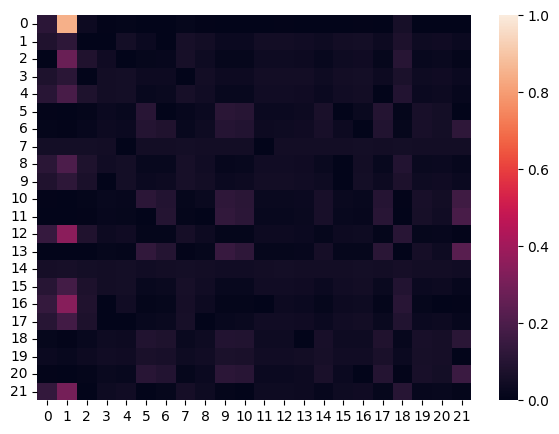

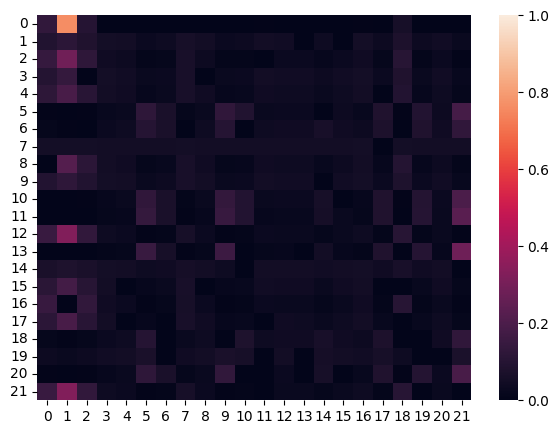

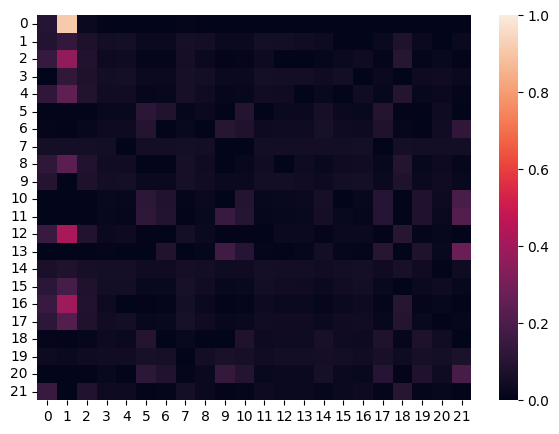

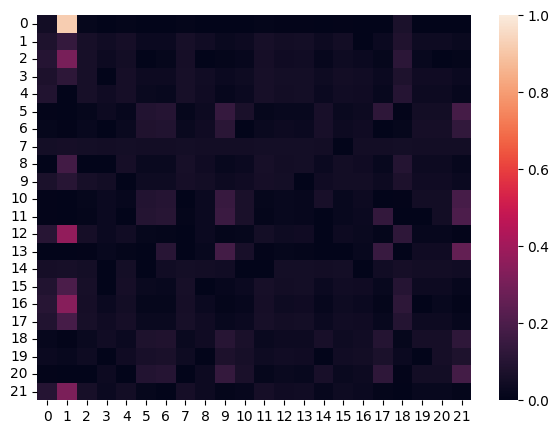

In [22]:
def convert_ids_to_chars(mapping, tensor_1d, eos_symbol: int = None):
    """
    Converts the input_ids tensor to a list representing the original input.
    Mapping is dict mapping int to str/char.

    tensor_1d: The sequence as provided to the model.
    """
    res = list()
    eos_idx = None
    try:
        tensor_1d = tensor_1d.detach().numpy()
    except:
        tensor_1d = tensor_1d.numpy()
    for i, x in enumerate(tensor_1d):
        if eos_symbol is not None and x==eos_symbol:
            eos_idx = i
        res.append(mapping[x])
    print("The original sequence: {}".format(" ".join(res)))
    return res, eos_idx

def plot_heatmaps(sequences, idx, attn_output, dataset, mapping):
    """
    Plots the heatmaps given by the output of the model.

    sequence: The sequence given as input to the model.
    idx: The index within the output.
    output: As returned by the distilbert model.
    dataset: The sequence-dataset.
    mapping: The mapping to get the sequence as we'd like to have it.
    """

    attn = attn_output[idx]
    num_heads = attn.shape[0]
    print("Number of heads: ", num_heads)

    sequence_list, eos_idx = convert_ids_to_chars(mapping=mapping, tensor_1d=sequences[idx], eos_symbol=dataset.EOS)
    for i in range(1, num_heads+1):
        plt.figure(figsize=(7, 5))
        sns.heatmap(attn[i-1, :eos_idx+1, :eos_idx+1], vmin=0, vmax=1)
        plt.plot()

plot_heatmaps(train_input_ids, 0, np_output, train_dataset, mapping)

## Attention outputs of TP

### Get the relevant fields

In [23]:
test_res = model(**get_forward_dict(test_input_ids, None, test_attn_mask))
test_predictions = np.argmax( test_res.logits.detach().numpy(), axis=-1)
test_predictions.shape

(10000,)

In [24]:
# find the positive label
train_dataset.label_dict

{'A': 0, 'R': 1}

In [25]:
POSITIVE_LABEL = train_dataset.label_dict["A"]
NEGATIVE_LABEL = train_dataset.label_dict["R"]

positive_prediction_idxs = np.where(test_predictions==POSITIVE_LABEL)[0]
positive_prediction_idxs

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [26]:
positive_label_idxs = np.where(np.array(test_labels)==POSITIVE_LABEL)[0]
positive_label_idxs

array([   0,    1,    2, ..., 9497, 9498, 9499])

In [27]:
_, _ = convert_ids_to_chars(mapping, test_input_ids[0], eos_symbol=train_dataset.PAD)

The original sequence: <SOS> a a a a a a a d c a d a d c b a c a d c <EOS> - - - - - - - - -


In [28]:
TP_indices = set(list(positive_prediction_idxs)).intersection(set(list(positive_label_idxs)))
len(TP_indices)

4970

In [29]:
tp_res = model(**get_forward_dict(test_input_ids[list(TP_indices)], None, test_attn_mask[list(TP_indices)], output_attentions=True))
tp_res.attentions[0].detach().numpy().shape

(4970, 4, 31, 31)

In [30]:
def two_a_highlighter_func(seq, mapping):
    """
    Takes in a sequence and returns a mask for the fields of interest, see also 'filter_attention' function.
    In this particular instance, we check the first two symbols after the SOS and see if they are a's. 
    If yes both those indices will be returned, else return an empty list.

    seq: np.array or list
    """
    pass

def one_a_highlighter_func(seq, mapping):
    """
    Takes in a sequence and returns the relevant indices, see also 'filter_attention' function.
    In this particular instance, we check the first two symbols after the SOS and see if they are a's. 
    If yes both those indices will be returned, else return an empty list.

    In this mask, the first a is 1, since this is the one making the string accepting or rejecting, the rest is 0.
    a's that are not in index 1 get a 2, since we are curious what the attention says about those.

    seq: np.array or list
    """
    res = [0] * len(seq)
    if mapping[seq[1]] == "a":
        res[1] = 1
    for i, x in enumerate(seq):
        if i != 1 and mapping[x]=="a":
            res[i]=2
    return res

def filter_attention(sequences, attentions, lengths, mapping, highlight_func):
    """
    This function gives the attention at the relevant indices. It stacks all attentions together,
    and returns them along with a mask for the attentions of interest and the unmapped symbols of 
    those.

    In the mask, uninteresting fields need a zero. Interesting fields can be numbered by ascending integers.

    IMPORTANT: If you want to do e.g. only at TP, ..., then you'll have to pre-filter that. sequences, attentions, 
    lengths are assumed to have same lengths in first dimension.

    sequences: np.array
    attentions: np.array
    lengths: list with the lengths.
    mapping: The casual mapping, from int to char
    highlight_func: A function that takes in a sequences and returns the indices of the symbols of interest.
    """
    attn_stack = None
    symbols = list()
    field_mask = list()
    
    for attn, seq, l in zip(attentions, sequences, lengths):
        if len(attn.shape) > 2:            
            # we have multiple heads
            attn = np.mean(attn, axis=0) # (seq_length, seq_length)
        attn = attn[:l]
        attn_stack = attn if attn_stack is None else np.vstack((attn_stack, attn))

        seq = list(seq[:l])
        
        #convert_ids_to_chars(mapping, torch.LongTensor(seq), eos_symbol=None) # for debugging
        
        symbols.extend(seq)
        field_mask.extend(highlight_func(seq, mapping))
    return attn_stack, symbols, field_mask

In [31]:
tp_attn, tp_symbols, tp_mask = filter_attention(
                                                               test_input_ids[list(TP_indices)].detach().numpy(), 
                                                               tp_res.attentions[0].detach().numpy(),
                                                               list(np.array(test_dataset.sequence_lengths)[list(TP_indices)]),
                                                               mapping,
                                                               one_a_highlighter_func
                                                               )

In [32]:
tp_attn.shape, len(tp_symbols), len(tp_mask)

((131724, 31), 131724, 131724)

### Get information about that stuff

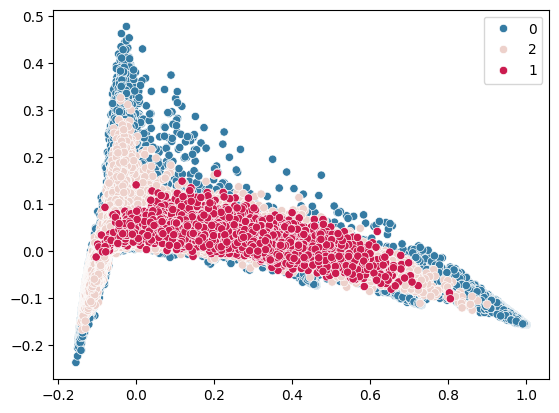

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
attn_transformed = pca.fit_transform(tp_attn)

zero_idx = np.where(np.array(tp_mask)==0)[0]
one_idx = np.where(np.array(tp_mask)==1)[0]
two_idx = np.where(np.array(tp_mask)==2)[0]

sns.scatterplot(x=attn_transformed[zero_idx, 0], y=attn_transformed[zero_idx, 1], hue=np.array(tp_mask)[zero_idx], palette="mako")
sns.scatterplot(x=attn_transformed[two_idx, 0], y=attn_transformed[two_idx, 1], hue=np.array(tp_mask)[two_idx])
sns.scatterplot(x=attn_transformed[one_idx, 0], y=attn_transformed[one_idx, 1], hue=np.array(tp_mask)[one_idx], palette="rocket")
#plt.savefig("rep.png")
plt.show()

## Test how well a classifier can separate the point clouds

### 1. Try a nearest neighbor

In [34]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors()
nn = nn.fit(tp_attn)

In [35]:
distances, neigh_idxs = nn.kneighbors(tp_attn)
distances.shape, neigh_idxs.shape

((131724, 5), (131724, 5))

In [36]:
distances[:5], neigh_idxs[:5]

(array([[2.10734243e-08, 1.03184537e-03, 1.19183189e-03, 1.43004720e-03,
         1.56248958e-03],
        [7.45058060e-09, 4.04454115e-02, 4.45818054e-02, 4.47560650e-02,
         4.60424245e-02],
        [0.00000000e+00, 3.69359327e-02, 4.01773000e-02, 4.06634204e-02,
         4.29421567e-02],
        [0.00000000e+00, 4.63687686e-02, 4.74375923e-02, 4.76983815e-02,
         4.77513095e-02],
        [0.00000000e+00, 2.91873753e-02, 2.98074830e-02, 3.03431236e-02,
         3.06652682e-02]]),
 array([[     0, 102064,  48493,  11604,  54499],
        [     1,    897,    716,      7,   2941],
        [     2,   4049,    694,  10961,  46975],
        [     3,   5485,   2383,   5424,   3206],
        [     4,     57,   8752,   8346,   1951]]))

In [37]:
test = neigh_idxs[one_idx, 1]
np.array(tp_mask)[test]

array([0, 0, 0, ..., 2, 1, 0])

## Attn outputs of TN

In [38]:
negative_prediction_idxs = np.where(test_predictions==NEGATIVE_LABEL)[0]
negative_label_idxs = np.where(np.array(test_labels)==NEGATIVE_LABEL)[0]

negative_prediction_idxs, negative_label_idxs

(array([ 436,  475,  477, ..., 9967, 9968, 9996]),
 array([ 500,  501,  502, ..., 9997, 9998, 9999]))

In [39]:
TN_indices = set(list(negative_prediction_idxs)).intersection(set(list(negative_label_idxs)))

tn_res = model(**get_forward_dict(test_input_ids[list(TN_indices)], None, test_attn_mask[list(TN_indices)], output_attentions=True))
tn_res.attentions[0].detach().numpy().shape

len(TN_indices)

4006

In [40]:
def first_char_highlighter_func(seq, mapping):
    """
    Only highlights first char of the sequence.

    seq: np.array or list
    """
    res = [0] * len(seq)
    res[1] = 1
    return res

tn_attn, tn_symbols, tn_mask = filter_attention(
                                                               test_input_ids[list(TN_indices)].detach().numpy(), 
                                                               tn_res.attentions[0].detach().numpy(),
                                                               list(np.array(test_dataset.sequence_lengths)[list(TN_indices)]),
                                                               mapping,
                                                               first_char_highlighter_func
                                                               )

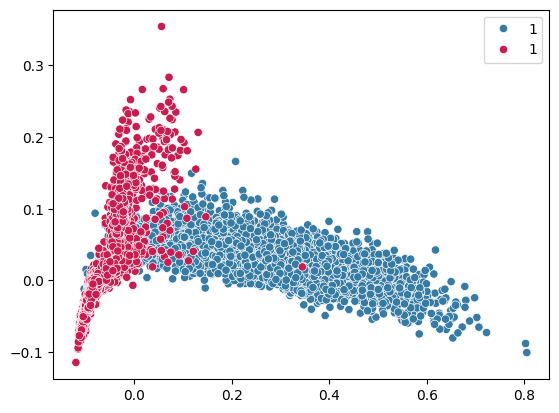

In [41]:
pca = PCA(n_components=2)
tp_attn_transformed = pca.fit_transform(tp_attn)
tn_attn_transformed = pca.fit_transform(tn_attn)

tp_one_idx = np.where(np.array(tp_mask)==1)[0]
tn_one_idx = np.where(np.array(tn_mask)==1)[0]

sns.scatterplot(x=tp_attn_transformed[tp_one_idx, 0], y=tp_attn_transformed[tp_one_idx, 1], hue=np.array(tp_mask)[tp_one_idx], palette="mako")
sns.scatterplot(x=tn_attn_transformed[tn_one_idx, 0], y=tn_attn_transformed[tn_one_idx, 1], hue=np.array(tn_mask)[tn_one_idx], palette="rocket")
#plt.savefig("rep.png")
plt.show()

In [42]:
tn_a_idxs = np.where(np.logical_and(np.array(tn_symbols)==train_dataset.symbol_dict["a"], np.array(tn_mask) == 1))[0]
tn_no_a_idxs = np.where(np.logical_and(np.array(tn_symbols)!=train_dataset.symbol_dict["a"], np.array(tn_mask) == 1))[0]

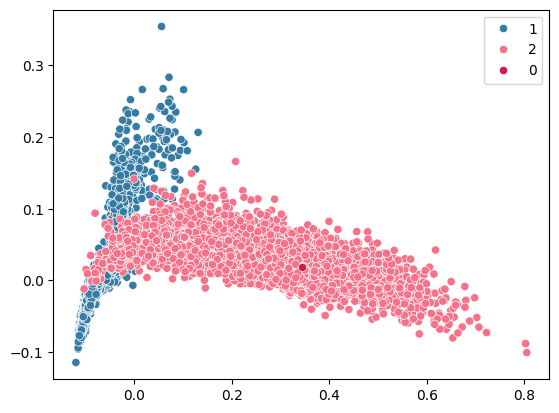

In [43]:
sns.scatterplot(x=tn_attn_transformed[tn_no_a_idxs, 0], y=tn_attn_transformed[tn_no_a_idxs, 1], hue=np.array([1]*len(tn_no_a_idxs)), palette="mako")
sns.scatterplot(x=tp_attn_transformed[tp_one_idx, 0], y=tp_attn_transformed[tp_one_idx, 1], hue=np.array([2]*len(tp_one_idx)), palette="husl")
sns.scatterplot(x=tn_attn_transformed[tn_a_idxs, 0], y=tn_attn_transformed[tn_a_idxs, 1], hue=np.array([0]*len(tn_a_idxs)), palette="rocket")
plt.savefig("rep.png")
plt.show()

## Check out the first character. Can we discriminate?

In [44]:
def first_char_highlighter(seq, mapping):
    """
    Takes in a sequence and returns the relevant indices, see also 'filter_attention' function.
    In this particular instance, we check the first two symbols after the SOS and see if they are a's. 
    If yes both those indices will be returned, else return an empty list.

    In this mask, the first a is 1, since this is the one making the string accepting or rejecting, the rest is 0.
    a's that are not in index 1 get a 2, since we are curious what the attention says about those.

    seq: np.array or list
    """
    res = [0] * len(seq)
    if mapping[seq[1]] == "a":
        res[1] = 1
    else:
        res[1] = 2
    return res

In [45]:
test_res = model(**get_forward_dict(test_input_ids, None, test_attn_mask, output_attentions=True))

test_attn, test_symbols, test_mask = filter_attention(
                                                               test_input_ids.detach().numpy(), 
                                                               test_res.attentions[0].detach().numpy(),
                                                               list(np.array(test_dataset.sequence_lengths)),
                                                               mapping,
                                                               first_char_highlighter
                                                               )

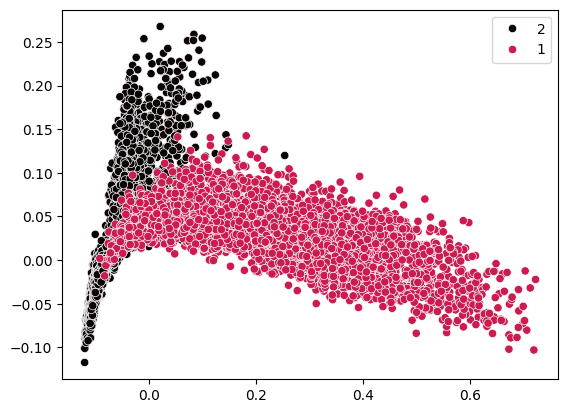

In [46]:
pca = PCA(n_components=2)
test_attn_transformed = pca.fit_transform(test_attn)

test_one_idx = np.where(np.array(test_mask)==1)[0]
test_two_idx = np.where(np.array(test_mask)==2)[0]

sns.scatterplot(x=test_attn_transformed[test_two_idx, 0], y=test_attn_transformed[test_two_idx, 1], hue=np.array(test_mask)[test_two_idx], palette="mako")
sns.scatterplot(x=test_attn_transformed[test_one_idx, 0], y=test_attn_transformed[test_one_idx, 1], hue=np.array(test_mask)[test_one_idx], palette="rocket")
#plt.savefig("rep.png")
plt.show()

## Question: Does it generalize to shorter strings?

In [47]:
symbol_dict = {k: v for k, v in train_dataset.symbol_dict.items()}
symbol_dict["<SOS>"] = train_dataset.SOS
symbol_dict["<EOS>"] = train_dataset.EOS
symbol_dict["<PAD>"] = train_dataset.PAD

def encode_sequences(sequences: list, symbol_dict: dict, maxlen: int):
    """
    Encodes the sequences and returns a tensor. sequences is list of list.
    Shape of result: (len(sequences, maxlen+2)), with +2 for SOS and EOS

    => maxlen must be maximum length without SOS and EOS!!!
    """
    res = torch.ones((len(sequences), maxlen+2), dtype=torch.int64) * symbol_dict["<PAD>"]
    lengths = list()
    for i, seq in enumerate(sequences):
        lengths.append(len(seq)+2) # plus 2 for SOS, EOS
        res[i, 0] = symbol_dict["<SOS>"]
        for j, symbol in enumerate(seq):
            res[i, j+1] = symbol_dict[symbol]
        res[i, j+2] = symbol_dict["<EOS>"]
    return res, lengths
symbol_dict

{'a': 0, 'd': 1, 'c': 2, 'b': 3, '<SOS>': 4, '<EOS>': 5, '<PAD>': 6}

In [48]:
int_to_char_map = {v: k for k, v in symbol_dict.items()}

def map_to_chars(sequences, int_to_char_map):
    for i, seq in enumerate(sequences):
        for j, s in enumerate(seq):
            sequences[i][j] = int_to_char_map[s]
    return sequences

In [49]:
sequences = [
    [0],
    [7],
    [0, 7],
    [0, 7, 7],
    [0, 1, 1, 1],
    [0, 6, 5, 2],
    [0, 11],
    [0, 4, 9],
    [0, 1, 1, 1, 7],
    [1], 
    [1, 7],
    [1, 0, 7]
]

encoded_s = map_to_chars(sequences, int_to_char_map)
x_input, lengths = encode_sequences(encoded_s, symbol_dict, MAX_STRING_LENGTH)
x_mask = construct_attn_mask(lengths, train_dataset.maxlen)

with torch.no_grad():
    outputs = model(**get_forward_dict(x_input, None, x_mask, output_attentions=True))
encoded_s, F.softmax(outputs.logits, dim=1), train_dataset.label_dict

KeyError: 7

In [ ]:
x_input, lengths, x_mask

## How do the internals look on shorter sequences?

In [ ]:
def new_first_char_highlighter(seq, mapping):
    """
    Takes in a sequence and returns the relevant indices, see also 'filter_attention' function.
    In this particular instance, we check the first two symbols after the SOS and see if they are a's. 
    If yes both those indices will be returned, else return an empty list.

    In this mask, the first a is 1, since this is the one making the string accepting or rejecting, the rest is 0.
    a's that are not in index 1 get a 2, since we are curious what the attention says about those.

    seq: np.array or list
    """
    res = [0] * len(seq)
    if mapping[seq[1]] == "a":
        res[1] = 3
    else:
        res[1] = 4
    return res

s_attn, s_symbols, s_mask = filter_attention(
                                                               x_input.detach().numpy(), 
                                                               outputs.attentions[0].detach().numpy(),
                                                               list(np.array(lengths)),
                                                               mapping,
                                                               new_first_char_highlighter
                                                               )

In [ ]:
pca = PCA(n_components=2)
test_attn_transformed = pca.fit_transform(test_attn)

test_one_idx = np.where(np.array(test_mask)==1)[0]
test_two_idx = np.where(np.array(test_mask)==2)[0]

s_attn_transformed = pca.transform(s_attn)

s_three_idx = np.where(np.array(s_mask)==3)[0]
s_four_idx = np.where(np.array(s_mask)==4)[0]

sns.scatterplot(x=test_attn_transformed[test_two_idx, 0], y=test_attn_transformed[test_two_idx, 1], hue=np.array(test_mask)[test_two_idx], palette="mako")
sns.scatterplot(x=test_attn_transformed[test_one_idx, 0], y=test_attn_transformed[test_one_idx, 1], hue=np.array(test_mask)[test_one_idx], palette="rocket")

sns.scatterplot(x=s_attn_transformed[s_three_idx, 0], y=s_attn_transformed[s_three_idx, 1], hue=np.array(s_mask)[s_three_idx], palette="hls")
sns.scatterplot(x=s_attn_transformed[s_four_idx, 0], y=s_attn_transformed[s_four_idx, 1], hue=np.array(s_mask)[s_four_idx], palette="Paired")

#plt.savefig("rep.png")
plt.show()